### exp: eqtl prediction, sign prediction, enformer_pca for machine learning

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Esophagus_Mucosa'
data_path = '../../../../../datasets_embedding/enformer_pca/eqtl_datasets/sign_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed1030/'
# set seed
seed = 1030
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [4]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

              variant_id label  \
0   chr1_1407232_G_C_b38     1   
1   chr1_2493455_T_C_b38     1   
2  chr1_16889585_T_C_b38     1   
3  chr1_20508117_C_A_b38     1   
4  chr1_22025454_G_T_b38     1   

                                 enformer_pca_before  \
0  [[202.36273, 688.57306, -40.228397, -82.51773,...   
1  [[-65.29498, 8.857524, -16.338726, 52.522667, ...   
2  [[-83.12351, 22.751055, -44.277607, 6.292816, ...   
3  [[-46.711304, -49.93935, -5.2461877, 22.846964...   
4  [[-30.531317, -72.42038, -63.15713, 9.621544, ...   

                                  enformer_pca_after  
0  [[204.92616, 687.50775, -40.21996, -83.023834,...  
1  [[-65.29567, 8.846896, -16.341778, 52.489758, ...  
2  [[-83.52669, 22.351473, -44.16648, 7.162715, -...  
3  [[-47.005497, -49.855995, -5.0390067, 22.79902...  
4  [[-30.66005, -72.46989, -63.306225, 6.5045924,...  
X_train shape: (380, 17920)
Y_train shape: (380,)
X_test shape: (43, 17920)
Y_test shape: (43,)


In [5]:
print(train_data['label'].unique())

[0 1]


##### model 1: xgboost

In [6]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 10}
{'max_depth': 9}


accuracy:0.4883720930232558
precision:0.5294117647058824
recall:0.391304347826087
f1-score:0.45


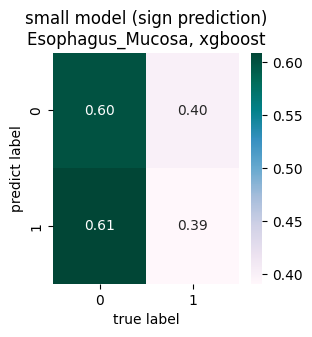

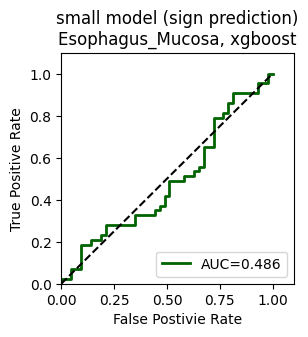

In [7]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [8]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 6}
{'num_leaves': 14}


[LightGBM] [Info] Number of positive: 174, number of negative: 206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.427330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284447
[LightGBM] [Info] Number of data points in the train set: 380, number of used features: 17920
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457895 -> initscore=-0.168821
[LightGBM] [Info] Start training from score -0.168821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

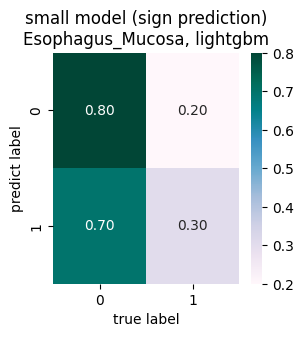

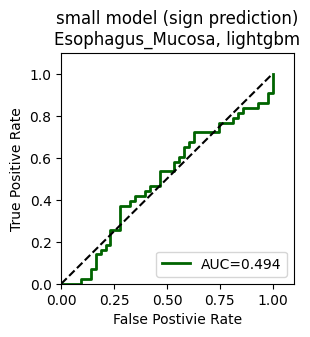

In [9]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 73}
{'max_depth': 9}


accuracy:0.4186046511627907
precision:0.375
recall:0.13043478260869565
f1-score:0.1935483870967742


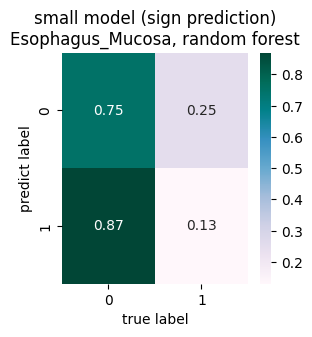

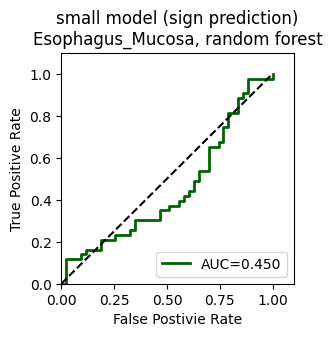

In [11]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 233}

accuracy:0.46511627906976744
precision:0.0
recall:0.0
f1-score:0.0


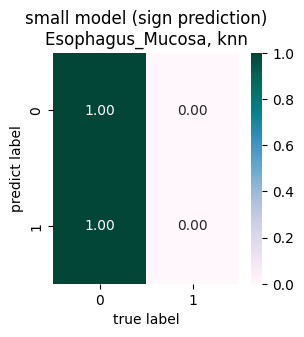

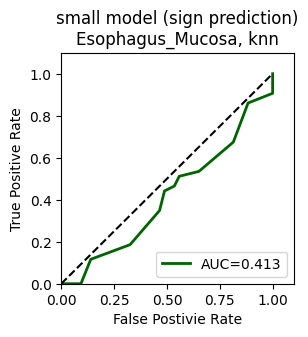

In [13]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

In [ ]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [ ]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

##### model 1: xgboost

In [ ]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

In [ ]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

In [ ]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

In [ ]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

In [ ]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

In [ ]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [ ]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

##### model 1: xgboost

In [ ]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBClassifier(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='roc_auc')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

In [ ]:
ml_model = model_list[0]
clf_xgb = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMClassifier(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='roc_auc')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

In [ ]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMClassifier(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_score = clf_lgb.predict(X_test)                                   
y_score_pro = clf_lgb.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} 
rfModel = RandomForestClassifier(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

In [ ]:
ml_model = model_list[2]
clf_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_score = clf_rf.predict(X_test)                                   
y_score_pro = clf_rf.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsClassifier()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

In [ ]:
ml_model = model_list[3]
clf_knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_score = clf_knn.predict(X_test)                                   
y_score_pro = clf_knn.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} 
svmModel = SVC(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

In [ ]:
ml_model = model_list[4]
clf_svm = SVC(probability = True, gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_score = clf_svm.predict(X_test)                                   
y_score_pro = clf_svm.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()